# Ramsey experiments for sensing a $\sigma_z$ perturbation

This notebook illustrates a few basic points about using Ramsey experiments for sensing a $\sigma_z$ perturbation of a quantum two-level system.

In [1]:
# Import the plotting library
using CairoMakie
using LaTeXStrings

# Import the simulation code (Revise -> includet() makes it automatically update when
# the files are modified).
using Revise
includet("experiments.jl")

# Import some auxiliary plotting code.
includet("plot_helpers.jl")

The most basic experiment is just to measure the phase accumulation using a Ramsey sequence (see source code). If the pulses are ideal, this works within the range (-π/2, π/2):

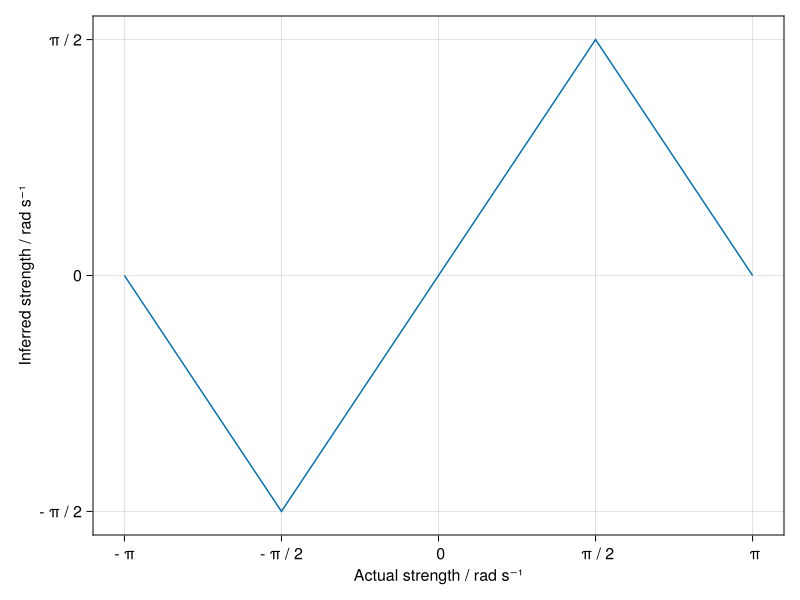

In [2]:
duration = 1.0
actual_strengths = range(-π, π, length=301)
measured_strengths = map(actual_strengths) do actual_strength
    system = BasicSystem(
        perturbation_strength=actual_strength,
        detuning_strength=0.0,
        rabi_frequency_scale=1.0
    )
    measure_simple_ramsey(system, trivial_wait_sequence(duration)) / duration
end

fig = Figure()
ax = Axis(
    fig[1, 1],
    xlabel="Actual strength / rad s⁻¹",
    ylabel="Inferred strength / rad s⁻¹"    
)
set_pi_axis_labels!(ax, -π, π, 1//2)
lines!(ax, actual_strengths, measured_strengths)
fig

By measuring in two axes (here, four), we can cover the entire range:

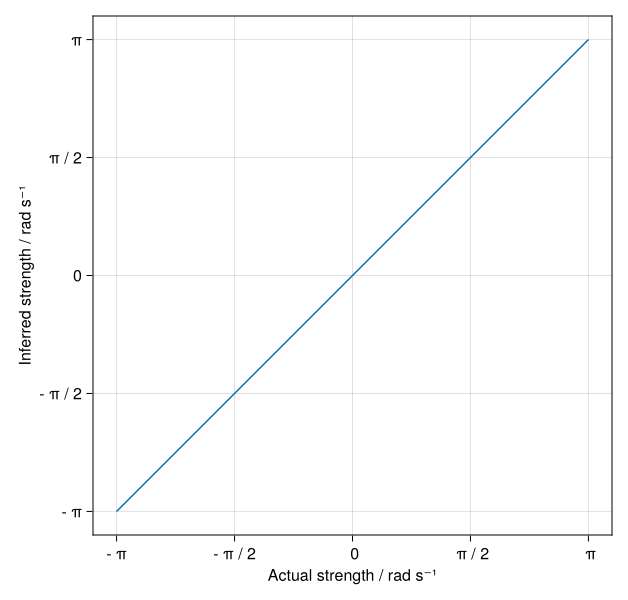

In [3]:
duration = 1.0
actual_strengths = range(-π, π, length=301)
measured_strengths = map(actual_strengths) do actual_strength
    system = BasicSystem(
        perturbation_strength=actual_strength,
        detuning_strength=0.0,
        rabi_frequency_scale=1.0
    )
    measure_four_point_ramsey(system, trivial_wait_sequence(duration)) / duration
end

fig = Figure()
ax = Axis(
    fig[1, 1],
    xlabel="Actual strength / rad s⁻¹",
    ylabel="Inferred strength / rad s⁻¹"    
)
set_pi_axis_labels!(ax, -π, π, 1//2)
lines!(ax, actual_strengths, measured_strengths)
colsize!(fig.layout, 1, Aspect(1, 1.0))
resize_to_layout!(fig)
fig

Without a spin-echo, a background $\sigma_z$ term (e.g. from qubit frequency miscalibration) leads to an offset in what we are trying to measure. A spin echo fixes this:

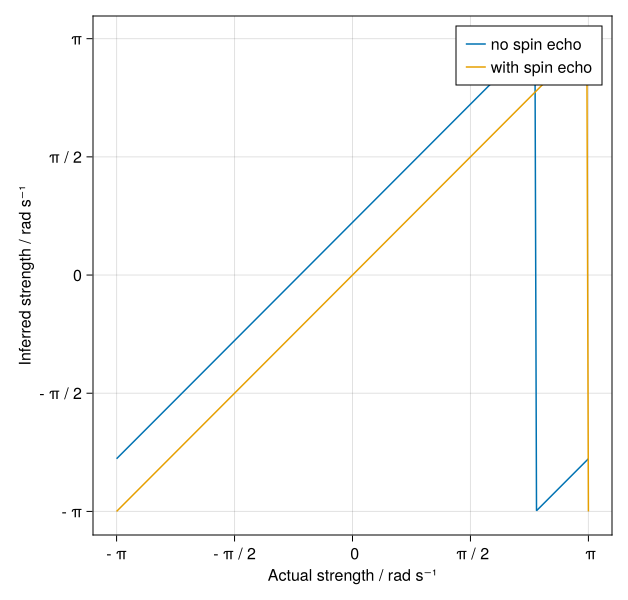

In [4]:
duration = 1.0
actual_strengths = range(-π, π, length=301)
measured_strengths = map(actual_strengths) do actual_strength
    system = BasicSystem(
        perturbation_strength=actual_strength,
        detuning_strength=0.7,
        rabi_frequency_scale=1.0
    )
    (
        measure_four_point_ramsey(system, trivial_wait_sequence(duration)) / duration,
        measure_four_point_ramsey(system, spin_echo_wait_sequence(duration, 0.0)) / duration
    )
end

fig = Figure()
ax = Axis(
    fig[1, 1],
    xlabel="Actual strength / rad s⁻¹",
    ylabel="Inferred strength / rad s⁻¹"    
)
set_pi_axis_labels!(ax, -π, π, 1//2)
lines!(ax, actual_strengths, first.(measured_strengths), label="no spin echo")
lines!(ax, actual_strengths, last.(measured_strengths), label="with spin echo")
axislegend(ax)
colsize!(fig.layout, 1, Aspect(1, 1.0))
resize_to_layout!(fig)
fig

## Behaviour under coherent under-rotations

If the Rabi frequency is different (here, lower) than expected, i.e. the pulses are shy of an actual π/2 or π pulse, we get systematic errors:

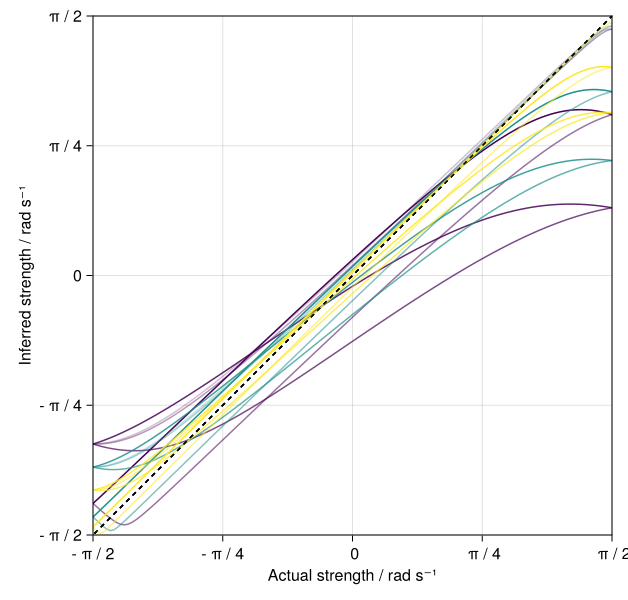

In [5]:
fig = Figure()
ax = Axis(
    fig[1, 1],
    xlabel="Actual strength / rad s⁻¹",
    ylabel="Inferred strength / rad s⁻¹"    
)
set_pi_axis_labels!(ax, -π, π, 1//4)
rabi_frequency_scales = [0.8, 0.85, 0.9]
for (i, rabi_frequency_scale) in enumerate(rabi_frequency_scales)
    for spin_echo_phase in range(-π, π, length=7)
        duration = 1.0
        actual_strengths = range(-π, π, length=301)
        measured_strengths = map(actual_strengths) do actual_strength
            system = BasicSystem(;
                perturbation_strength=actual_strength,
                detuning_strength=0.0,
                rabi_frequency_scale
            )
            wait_seq = spin_echo_wait_sequence(duration, spin_echo_phase)
            measure_simple_ramsey(system, wait_seq) / duration
        end
        lines!(ax, actual_strengths, measured_strengths,
            color=i,
            colorrange=(1, max(2, length(rabi_frequency_scales))),
            alpha=0.1 + 0.9 * (spin_echo_phase + π) / 2π
        )
    end
    lines!(ax, [-π, π], [-π, π], color=:black, linestyle=:dash)
end
xlims!(ax, -π/2, π/2)
ylims!(ax, -π/2, π/2)
colsize!(fig.layout, 1, Aspect(1, 1.0))
resize_to_layout!(fig)
fig

This is also true for the four-point measurement:

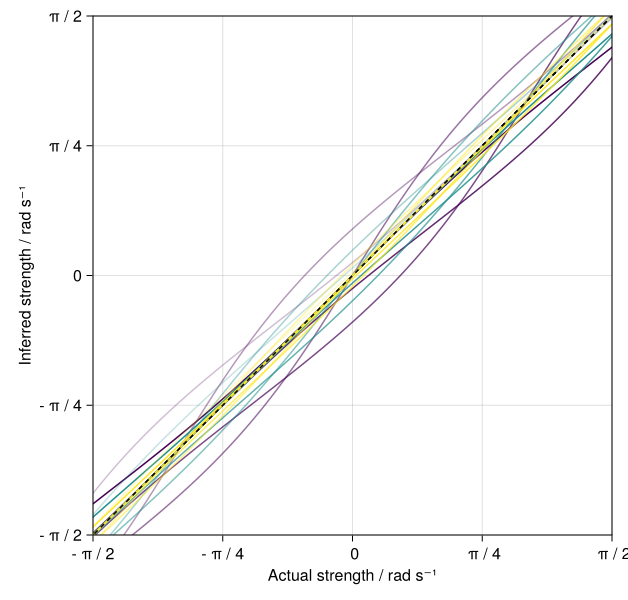

In [6]:
fig = Figure()
ax = Axis(
    fig[1, 1],
    xlabel="Actual strength / rad s⁻¹",
    ylabel="Inferred strength / rad s⁻¹"    
)
set_pi_axis_labels!(ax, -π, π, 1//4)
rabi_frequency_scales = [0.8, 0.85, 0.9]
for (i, rabi_frequency_scale) in enumerate(rabi_frequency_scales)
    for spin_echo_phase in range(-π, π, length=7)
        duration = 1.0
        actual_strengths = range(-π, π, length=301)
        measured_strengths = map(actual_strengths) do actual_strength
            system = BasicSystem(;
                perturbation_strength=actual_strength,
                detuning_strength=0.0,
                rabi_frequency_scale
            )
            wait_seq = spin_echo_wait_sequence(duration, spin_echo_phase)
            measure_four_point_ramsey(system, wait_seq) / duration
        end
        lines!(ax, actual_strengths, measured_strengths,
            color=i,
            colorrange=(1, max(2, length(rabi_frequency_scales))),
            alpha=0.1 + 0.9 * (spin_echo_phase + π) / 2π
        )
    end
    lines!(ax, [-π, π], [-π, π], color=:black, linestyle=:dash)
end
xlims!(ax, -π/2, π/2)
ylims!(ax, -π/2, π/2)
colsize!(fig.layout, 1, Aspect(1, 1.0))
resize_to_layout!(fig)
fig

### Multi-spin-echo sequences

If the background detuning isn't actually constant, but e.g. slowly drifts (not simulated here), we might need more than one spin-echo pulse to achieve the desired total interrogation time. If we just do them with the same phase, we unsurprisingly become much more sensitive to under/over-rotation errors:

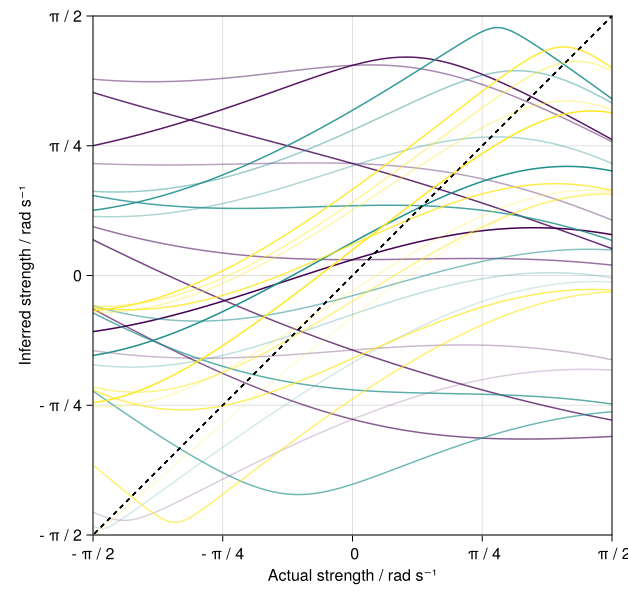

In [7]:
fig = Figure()
ax = Axis(
    fig[1, 1],
    xlabel="Actual strength / rad s⁻¹",
    ylabel="Inferred strength / rad s⁻¹"    
)
set_pi_axis_labels!(ax, -π, π, 1//4)
rabi_frequency_scales = [0.8, 0.85, 0.9]
for (color_idx, rabi_frequency_scale) in enumerate(rabi_frequency_scales)
    for spin_echo_phase in range(-π, π, length=11)
        duration = 1.0
        actual_strengths = range(-π, π, length=301)
        measured_strengths = map(actual_strengths) do actual_strength
            system = BasicSystem(;
                perturbation_strength=actual_strength,
                detuning_strength=0.0,
                rabi_frequency_scale
            )
            spin_echo_phases = ones(5) * spin_echo_phase
            wait_seq = multi_spin_echo_wait_sequence(duration, spin_echo_phases)
            measure_simple_ramsey(system, wait_seq) / duration
        end
        lines!(ax, actual_strengths, measured_strengths,
            color=color_idx,
            colorrange=(1, max(2, length(rabi_frequency_scales))),
            alpha=0.1 + 0.9 * (spin_echo_phase + π) / 2π
        )
    end
    lines!(ax, [-π, π], [-π, π], color=:black, linestyle=:dash)
end
xlims!(ax, -π/2, π/2)
ylims!(ax, -π/2, π/2)
colsize!(fig.layout, 1, Aspect(1, 1.0))
resize_to_layout!(fig)
fig

The four-point measurement doesn't make this any better at all:

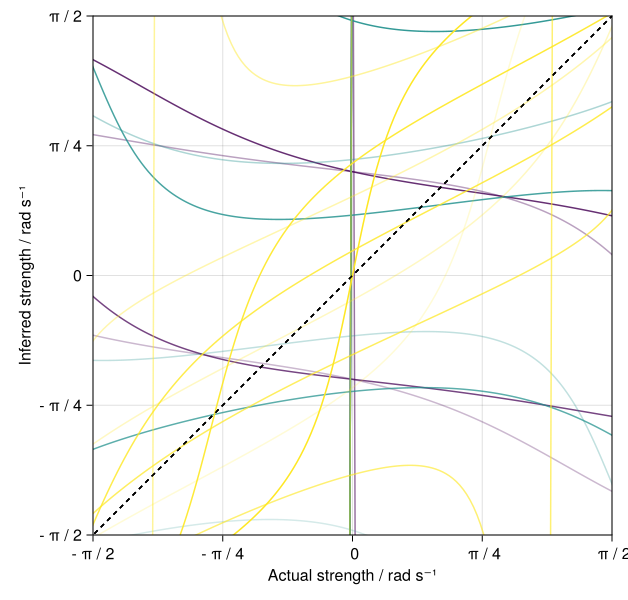

In [8]:
fig = Figure()
ax = Axis(
    fig[1, 1],
    xlabel="Actual strength / rad s⁻¹",
    ylabel="Inferred strength / rad s⁻¹"    
)
set_pi_axis_labels!(ax, -π, π, 1//4)
rabi_frequency_scales = [0.8, 0.85, 0.9]
for (color_idx, rabi_frequency_scale) in enumerate(rabi_frequency_scales)
    for spin_echo_phase in range(-π, π, length=11)
        duration = 1.0
        actual_strengths = range(-π, π, length=301)
        measured_strengths = map(actual_strengths) do actual_strength
            system = BasicSystem(;
                perturbation_strength=actual_strength,
                detuning_strength=0.0,
                rabi_frequency_scale
            )
            wait_seq = multi_spin_echo_wait_sequence(duration, ones(5) * spin_echo_phase)
            measure_four_point_ramsey(system, wait_seq) / duration
        end
        lines!(ax, actual_strengths, measured_strengths,
            color=color_idx,
            colorrange=(1, max(2, length(rabi_frequency_scales))),
            alpha=0.1 + 0.9 * (spin_echo_phase + π) / 2π
        )
    end
    lines!(ax, [-π, π], [-π, π], color=:black, linestyle=:dash)
end
xlims!(ax, -π/2, π/2)
ylims!(ax, -π/2, π/2)
colsize!(fig.layout, 1, Aspect(1, 1.0))
resize_to_layout!(fig)
fig